
# Problem Description
In this project, I aim to predict the hourly closing prices of the EUR/USD currency pair using a Long Short-Term Memory (LSTM) neural network. Accurate prediction of currency exchange rates is a critical tool for forex traders, financial analysts, and investors to make informed decisions. 
The dataset includes various features such as opening, high, low, and closing prices along with technical indicators derived from price data, like SMA, RSI, and MACD. By leveraging these features and the LSTM model's ability to capture time-series data analysis, we aim to achieve robust and reliable predictions.

# EDA Procedure
The Exploratory Data Analysis (EDA) involved inspecting the dataset to understand its structure, distribution, and key characteristics. 
- We visualized the closing prices over time to identify trends and patterns. 
- Added technical indicators such as Simple Moving Averages (SMA), Relative Strength Index (RSI), and Moving Average Convergence Divergence (MACD) to enhance the dataset for Hyperpareter Tuning Features. 
- Summary statistics were computed, and missing values were handled by dropping rows with NaN values resulting from the rolling window calculations for the indicators.

### Note:
- Most of the data preprocessing and collection is from OANDA API and captured using the addition scripts('collect_historical_data.py)
- **defs.py** template included. Need to create credentials for OANDA API and get your own acccess code

```python
# Placeholder definitions. Replace with actual values.
OANDA_URL = "https://api-fxpractice.oanda.com/v3"
ACCOUNT_ID = "your_account_id"
SECURE_HEADER = {
    "Authorization": "Bearer your_access_token"
}

```

# Analysis
The analysis phase involved building and training an LSTM model for time series prediction. We first scaled the data and created sequences of 24 hours as inputs for the model because I wanted to essentially predict the next 24 hour price data. The LSTM network was designed with two layers, each followed by a Dropout layer to prevent overfitting.
## Hyperparameterized Model (2nd iteration)
I employed new technical indicators and deployed a new model with additional layers and dropout layers. I ran into computaiton resourcing issues with Google Colabs but further development of this model is in plan for the future


# Discussion/Conclusion/Results
The results of the inital model gave prediction prices for the next 24 hour price points for the EUR_USD currency pair. However, in foresight I should have ran this on a day with tradeable data. Since I ran and trained the model over the weekend it prevented me from geting the actual price to compare performance. The intial model needs to be further developed because the Fiancial currency markets are much more volatile to be accurately predicted using price data alone. With the further development I plan to implement
- Sentiment Analyis
- Fine-Tuned Candlestick analysis and Price Action
- Risk Management Systems
- Extensive Backtesting Automations


In conclusion, the LSTM model could be a profitable algorithm to be used to predict the hourly closing prices of the EUR/USD currency pair and other Currency pair markets. It shows it's promises in this use case for me by demonstrating the model's capability to capture temporal dependencies in time series data. The addition of more advanced technical indicators will further enhanced the model's performance and layering in other models developed will attribute to higher accuracies in theory. While the results are promising, further improvements will be made by incorporating more features, fine-tuning hyperparameters, and exploring other deep learning architectures. 




In [12]:
#installation of  libraries not in google Coiab
!pip install ta
!pip install pandas_ta

In [13]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ta as tech

# from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import pandas_ta as ta

# Helper Functions

In [14]:
plot_colors = ['#043ef9','#eb5334', '#34eb37']

def plot_candles(df_plot):

    fig = go.Figure()
    #add trace whenever dealing with bars or candles
    fig.add_trace(go.Candlestick(
        x = df_plot.index, open= df_plot.mid_o, high=df_plot.mid_h, low=df_plot.mid_l, close=df_plot.mid_c,
        line=dict(width=1), opacity=1,
        increasing_fillcolor='#24A06B',
        decreasing_fillcolor='#CC2E3C',
        increasing_line_color='#2EC886',
        decreasing_line_color='#FF3A4C'
    ))


    #Styling figure
    fig.update_layout(
        width=1400,height=500,
        margin=dict(l=10,r=10,b=10,t=10),
        font=dict(size=10, color='#e1e1e1'),
        paper_bgcolor='#1e1e1e',
        plot_bgcolor='#1e1e1e'
    )
    fig.update_xaxes(
        gridcolor='#1f292f',
        showgrid=True,
        fixedrange=True,
        rangeslider=dict(visible=False),
        rangebreaks=[
            dict(bounds=['sat', 'mon']) #remove the gaps from the weekends
        ]
    )
    fig.update_yaxes(
        gridcolor='#1f292f',
        showgrid=True
    )
    fig.show()

In [15]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 4])  # mid_c is the target column
    return np.array(sequences), np.array(targets)

# ETL - Extract, Transform, Load

## OANDA Hourly EUR_USD
- Data from 2009 to 2024
  - January 1, 2009 to May 31, 2024



The data was collected from "oanda_api.py":
- Data collected using OANDA API
- ETL applied to data and stored as pickle file to retain etl formatting
  - time - datetime
  - Volume - int64
  - Open, Mid, Closing Prices = floats

In [26]:
df = pd.read_csv("/content/EUR_USD_H1.csv")
df.set_index('time', inplace=True)


In [27]:
df

Unnamed: 0  volume    mid_o    mid_h    mid_l  \
time                                                                       
2009-01-01 18:00:00+00:00           0      12  1.39809  1.39809  1.39631   
2009-01-01 19:00:00+00:00           1      52  1.39650  1.39876  1.39650   
2009-01-01 20:00:00+00:00           2      40  1.39853  1.39906  1.39842   
2009-01-01 21:00:00+00:00           3     214  1.39890  1.40444  1.39865   
2009-01-01 22:00:00+00:00           4     769  1.40440  1.40565  1.40005   
...                               ...     ...      ...      ...      ...   
2024-05-31 16:00:00+00:00         822    2602  1.08460  1.08522  1.08398   
2024-05-31 17:00:00+00:00         823    2109  1.08472  1.08526  1.08454   
2024-05-31 18:00:00+00:00         824    1803  1.08470  1.08491  1.08410   
2024-05-31 19:00:00+00:00         825    2591  1.08426  1.08514  1.08406   
2024-05-31 20:00:00+00:00         826    1530  1.08509  1.08524  1.08464   

                             mid_c    bid_o    bid_h    bid_l    bid_c  \
time                                                                     
2009-01-01 18:00:00+00:00  1.39631  1.39759  1.39759  1.39581  1.39581   
2009-01-01 19:00:00+00:00  1.39793  1.39600  1.39826  1.39600  1.39743   
2009-01-01 20:00:00+00:00  1.39890  1.39803  1.39856  1.39792  1.39840   
2009-01-01 21:00:00+00:00  1.40440  1.39840  1.40394  1.39815  1.40390   
2009-01-01 22:00:00+00:00  1.40041  1.40390  1.40515  1.39955  1.39991   
...                            ...      ...      ...      ...      ...   
2024-05-31 16:00:00+00:00  1.08474  1.08453  1.08515  1.08391  1.08467   
2024-05-31 17:00:00+00:00  1.08471  1.08465  1.08519  1.08447  1.08464   
2024-05-31 18:00:00+00:00  1.08426  1.08463  1.08484  1.08403  1.08419   
2024-05-31 19:00:00+00:00  1.08512  1.08419  1.08507  1.08399  1.08504   
2024-05-31 20:00:00+00:00  1.08486  1.08502  1.08517  1.08450  1.08476   

                             ask_o    ask_h    ask_l    ask_c  
time                                                           
2009-01-01 18:00:00+00:00  1.39859  1.39859  1.39681  1.39681  
2009-01-01 19:00:00+00:00  1.39700  1.39926  1.39700  1.39843  
2009-01-01 20:00:00+00:00  1.39903  1.39956  1.39892  1.39940  
2009-01-01 21:00:00+00:00  1.39940  1.40494  1.39915  1.40490  
2009-01-01 22:00:00+00:00  1.40490  1.40615  1.40055  1.40091  
...                            ...      ...      ...      ...  
2024-05-31 16:00:00+00:00  1.08468  1.08529  1.08405  1.08481  
2024-05-31 17:00:00+00:00  1.08479  1.08534  1.08461  1.08478  
2024-05-31 18:00:00+00:00  1.08478  1.08498  1.08418  1.08433  
2024-05-31 19:00:00+00:00  1.08434  1.08521  1.08413  1.08519  
2024-05-31 20:00:00+00:00  1.08516  1.08531  1.08471  1.08495  

[97684 rows x 14 columns]

# EDA - Exploratory Data Analysis
## EDA Procedure

The Exploratory Data Analysis (EDA) involved inspecting the dataset to understand its structure, distribution, and key characteristics. 
- We visualized the closing prices over time to identify trends and patterns. 
- Added technical indicators such as Simple Moving Averages (SMA), Relative Strength Index (RSI), and Moving Average Convergence Divergence (MACD) to enhance the dataset for Hyperpareter Tuning Features. 
- Summary statistics were computed, and missing values were handled by dropping rows with NaN values resulting from the rolling window calculations for the indicators.

### Note:
- Most of the data preprocessing and collection is from OANDA API and captured using the addition scripts('collect_historical_data.py)
- **defs.py** template included. Need to create credentials for OANDA API and get your own acccess code

```python
# Placeholder definitions. Replace with actual values.
OANDA_URL = "https://api-fxpractice.oanda.com/v3"
ACCOUNT_ID = "your_account_id"
SECURE_HEADER = {
    "Authorization": "Bearer your_access_token"
}

```



In [28]:
df.dtypes

Unnamed: 0      int64
volume          int64
mid_o         float64
mid_h         float64
mid_l         float64
mid_c         float64
bid_o         float64
bid_h         float64
bid_l         float64
bid_c         float64
ask_o         float64
ask_h         float64
ask_l         float64
ask_c         float64
dtype: object

In [29]:
df.shape

(97684, 14)

In [30]:
non_cols = ['time', 'volume']
price_columns = [x for x in df.columns if x not in non_cols]

price_columns

['Unnamed: 0',
 'mid_o',
 'mid_h',
 'mid_l',
 'mid_c',
 'bid_o',
 'bid_h',
 'bid_l',
 'bid_c',
 'ask_o',
 'ask_h',
 'ask_l',
 'ask_c']

In [31]:
#Plot candlesticks
df_plot = df.iloc[0:]
plot_candles(df_plot)

In [32]:
# Last 500 candles as of last date (5-31-2024)
df_plot = df.iloc[-500:]
plot_candles(df_plot)


# Analysis
The analysis phase involved building and training an LSTM model for time series prediction. We first scaled the data and created sequences of 24 hours as inputs for the model because I wanted to essentially predict the next 24 hour price data. The LSTM network was designed with two layers, each followed by a Dropout layer to prevent overfitting.
## Hyperparameterized Model (2nd iteration)
I employed new technical indicators and deployed a new model with additional layers and dropout layers. I ran into computaiton resourcing issues with Google Colabs but further development of this model is in plan for the future

In [33]:
# Select features and target variable
features = df[['mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c']]

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features)
# Create a dataframe with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=df.index)


[[0.79260806 0.79172337 0.79106211 ... 0.79251433 0.79186919 0.79026271]
 [0.7897705  0.79292314 0.79140162 ... 0.79371418 0.79220872 0.79315391]
 [0.7933933  0.79346035 0.79483239 ... 0.79425143 0.79563974 0.79488507]
 ...
 [0.23332263 0.23091111 0.23318562 ... 0.23089183 0.23320229 0.23258138]
 [0.23253739 0.23132297 0.23311414 ... 0.23130372 0.23311294 0.23411622]
 [0.23401863 0.23150204 0.23415053 ... 0.23148281 0.23414939 0.23368789]]


In [34]:
scaled_df

mid_o     mid_h     mid_l     mid_c     bid_o  \
time                                                                          
2009-01-01 18:00:00+00:00  0.792608  0.791723  0.791062  0.789467  0.791816   
2009-01-01 19:00:00+00:00  0.789770  0.792923  0.791402  0.792358  0.788979   
2009-01-01 20:00:00+00:00  0.793393  0.793460  0.794832  0.794089  0.792601   
2009-01-01 21:00:00+00:00  0.794054  0.803094  0.795243  0.803905  0.793262   
2009-01-01 22:00:00+00:00  0.803869  0.805261  0.797745  0.796784  0.803077   
...                             ...       ...       ...       ...       ...   
2024-05-31 16:00:00+00:00  0.233144  0.231466  0.232971  0.233430  0.233150   
2024-05-31 17:00:00+00:00  0.233358  0.231538  0.233972  0.233376  0.233364   
2024-05-31 18:00:00+00:00  0.233323  0.230911  0.233186  0.232573  0.233328   
2024-05-31 19:00:00+00:00  0.232537  0.231323  0.233114  0.234108  0.232543   
2024-05-31 20:00:00+00:00  0.234019  0.231502  0.234151  0.233644  0.234024   

                              bid_h     bid_l     bid_c     ask_o     ask_h  \
time                                                                          
2009-01-01 18:00:00+00:00  0.790911  0.790269  0.788661  0.793418  0.792514   
2009-01-01 19:00:00+00:00  0.792111  0.790609  0.791552  0.790580  0.793714   
2009-01-01 20:00:00+00:00  0.792648  0.794039  0.793283  0.794203  0.794251   
2009-01-01 21:00:00+00:00  0.802281  0.794450  0.803098  0.794864  0.803886   
2009-01-01 22:00:00+00:00  0.804448  0.796952  0.795978  0.804680  0.806053   
...                             ...       ...       ...       ...       ...   
2024-05-31 16:00:00+00:00  0.231454  0.232977  0.233431  0.233174  0.231447   
2024-05-31 17:00:00+00:00  0.231525  0.233977  0.233377  0.233371  0.231537   
2024-05-31 18:00:00+00:00  0.230899  0.233191  0.232574  0.233353  0.230892   
2024-05-31 19:00:00+00:00  0.231311  0.233120  0.234091  0.232568  0.231304   
2024-05-31 20:00:00+00:00  0.231490  0.234031  0.233591  0.234031  0.231483   

                              ask_l     ask_c  
time                                           
2009-01-01 18:00:00+00:00  0.791869  0.790263  
2009-01-01 19:00:00+00:00  0.792209  0.793154  
2009-01-01 20:00:00+00:00  0.795640  0.794885  
2009-01-01 21:00:00+00:00  0.796051  0.804701  
2009-01-01 22:00:00+00:00  0.798553  0.797580  
...                             ...       ...  
2024-05-31 16:00:00+00:00  0.232970  0.233438  
2024-05-31 17:00:00+00:00  0.233971  0.233384  
2024-05-31 18:00:00+00:00  0.233202  0.232581  
2024-05-31 19:00:00+00:00  0.233113  0.234116  
2024-05-31 20:00:00+00:00  0.234149  0.233688  

[97684 rows x 12 columns]

### Sequences for Time-Series Data
create 24 hour sequences for the forex data in order to find any daily patterns since the market is 24 hour cycles

In [35]:
sequence_length = 24

#Utilize create_sequences() function in the Helper Function Part

sequences, target = create_sequences(scaled_features, sequence_length)

In [36]:
# Split into training and test sets

train_size = int(len(sequences)* 0.8)

X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(78128, 24, 12)
(19532, 24, 12)
(78128,)
(19532,)


In [38]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# LSTM Model

In [39]:
# Baseline Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length,X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
#Train Model
model.fit(X_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
78128/78128 [==============================] - 497s 6ms/step - loss: 6.4477e-05
Epoch 2/10
78128/78128 [==============================] - 473s 6ms/step - loss: 1.5177e-05
Epoch 3/10
78128/78128 [==============================] - 470s 6ms/step - loss: 1.0200e-05
Epoch 4/10
78128/78128 [==============================] - 469s 6ms/step - loss: 8.2016e-06
Epoch 5/10
78128/78128 [==============================] - 474s 6ms/step - loss: 7.1773e-06
Epoch 6/10
78128/78128 [==============================] - 467s 6ms/step - loss: 6.5290e-06
Epoch 7/10
78128/78128 [==============================] - 463s 6ms/step - loss: 5.4962e-06
Epoch 8/10
78128/78128 [==============================] - 460s 6ms/step - loss: 5.0522e-06
Epoch 9/10
78128/78128 [==============================] - 462s 6ms/step - loss: 4.8638e-06
Epoch 10/10
78128/78128 [==============================] - 471s 6ms/step - loss: 4.3741e-06


In [41]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(model, 'eur_usd_baseline.pkl')

# # Load the model from the file
# model_from_joblib = joblib.load('filename.pkl')

# # Use the loaded model to make predictions
# model_from_joblib.predict(X_test)

['eur_usd_baseline.pkl']

In [42]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict_full = np.zeros((train_predict.shape[0], scaled_features.shape[1]))
test_predict_full = np.zeros((test_predict.shape[0], scaled_features.shape[1]))
train_predict_full[:, -1] = train_predict[:, 0]
test_predict_full[:, -1] = test_predict[:, 0]

train_predict = scaler.inverse_transform(train_predict_full)[:, -1]
test_predict = scaler.inverse_transform(test_predict_full)[:, -1]

# Inverse transform the actual values
y_train_full = np.zeros((y_train.shape[0], scaled_features.shape[1]))
y_test_full = np.zeros((y_test.shape[0], scaled_features.shape[1]))
y_train_full[:, -1] = y_train
y_test_full[:, -1] = y_test

y_train = scaler.inverse_transform(y_train_full)[:, -1]
y_test = scaler.inverse_transform(y_test_full)[:, -1]

# Create the indexes for plotting
train_index = df.index[sequence_length:train_size + sequence_length]
test_index = df.index[train_size + sequence_length + sequence_length:]

# Calculate and print the error metrics
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_predict)))


611/611 [==============================] - 2s 3ms/step
Train Mean Absolute Error: 0.00021814876799371844
Train Root Mean Squared Error: 0.0003257705506104775
Test Mean Absolute Error: 0.00033511334346659284
Test Root Mean Squared Error: 0.0010017973262265896


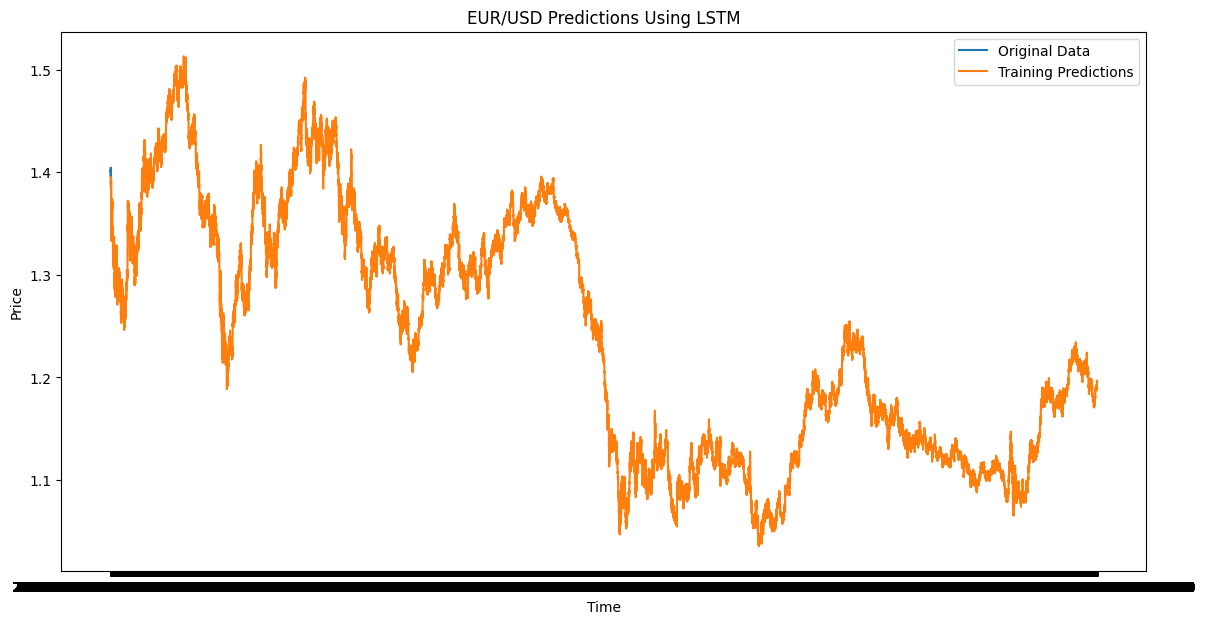

In [43]:
df_plot = df[:10]
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df_plot.index, df_plot['mid_c'], label='Original Data')
plt.plot(train_index, train_predict, label='Training Predictions')
# plt.plot(test_index, test_predict, label='Testing Predictions')
plt.title('EUR/USD Predictions Using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
print(train_index.shape)
print(train_predict.shape)
print(test_index.shape)
print(test_predict.shape)

# Generate new indices for extra predictions
last_index = test_index[-1] if isinstance(test_index[-1], pd.Timestamp) else pd.to_datetime(test_index[-1])
num_extra_predictions = len(test_predict) - len(test_index)
new_index = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=num_extra_predictions, freq='H')

# Combine the existing and new indices
combined_index = test_index.append(new_index)


# new_index = pd.date_range(start=test_index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
# new_index.shape

# combined_index = test_index.append(new_index)

print(combined_index.shape)


(78128,)
(78128,)
(19508,)
(19532,)
(19532,)


In [46]:
predictions_df = pd.DataFrame({'Values': test_predict}, index=combined_index)


In [47]:
predictions_df

Values
2021-04-15 15:00:00+00:00  1.196644
2021-04-15 16:00:00+00:00  1.197539
2021-04-15 17:00:00+00:00  1.198586
2021-04-15 18:00:00+00:00  1.197985
2021-04-15 19:00:00+00:00  1.197166
...                             ...
2024-06-01 16:00:00+00:00  1.084642
2024-06-01 17:00:00+00:00  1.084731
2024-06-01 18:00:00+00:00  1.084742
2024-06-01 19:00:00+00:00  1.084305
2024-06-01 20:00:00+00:00  1.085070

[19532 rows x 1 columns]

In [48]:
# # Getting Actuals for June 1 from yfinance
# import yfinance as yf

# # Download EUR/USD hourly data for June 1st, 2022
# actuals_df = yf.download(tickers='EURUSD=X', start='2024-06-01', end='2024-06-02', interval='1h')

# # Display the first 10 rows of the data
# print(actuals_df.head(10))

TypeError: tz must be string or tzinfo subclass.

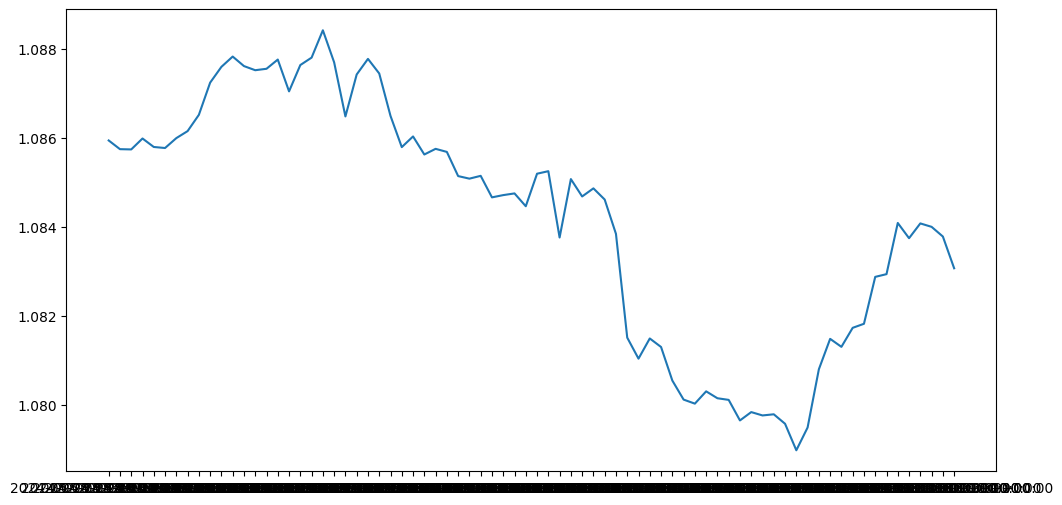

In [50]:
# Slice the DataFrame to get the last 100 rows
last_100 = predictions_df.iloc[-100:]

# # Define the split point
# split_point = len(last_100) - 24

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(last_100.index[:split_point], last_100['Values'][:split_point], label='Previous Data')
plt.plot(last_100.index[split_point:], last_100['Values'][split_point:], color='orange', label='Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time Series Data with Predictions')
plt.legend()
plt.show()


# Hyperparameterizing

In [16]:
data = pd.read_csv("/content/EUR_USD_H1.csv")
data.set_index('time', inplace=True)

# Adding indicators
data['SMA_20'] = data['mid_c'].rolling(window=20).mean()
data['SMA_50'] = data['mid_c'].rolling(window=50).mean()
data['RSI'] = tech.momentum.RSIIndicator(data['mid_c'], window=14).rsi()
data['MACD'] = tech.trend.MACD(data['mid_c']).macd()
data.dropna(inplace=True)


# Limit Features to indicators and volumes
features = ['mid_c', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'volume']
data = data[features]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [17]:
data

mid_c    SMA_20    SMA_50        RSI      MACD  \
time                                                                          
2009-01-05 14:00:00+00:00  1.36341  1.381290  1.388051  32.931523 -0.008040   
2009-01-05 15:00:00+00:00  1.36341  1.379949  1.387393  32.931523 -0.008080   
2009-01-05 16:00:00+00:00  1.35766  1.378321  1.386587  29.165656 -0.008478   
2009-01-05 17:00:00+00:00  1.35818  1.376698  1.385773  29.945858 -0.008652   
2009-01-05 18:00:00+00:00  1.36016  1.375263  1.384888  32.973179 -0.008532   
...                            ...       ...       ...        ...       ...   
2024-05-31 16:00:00+00:00  1.08474  1.083748  1.082326  54.827901  0.000841   
2024-05-31 17:00:00+00:00  1.08471  1.083817  1.082398  54.647396  0.000776   
2024-05-31 18:00:00+00:00  1.08426  1.083862  1.082452  51.887890  0.000681   
2024-05-31 19:00:00+00:00  1.08512  1.083962  1.082527  56.417347  0.000667   
2024-05-31 20:00:00+00:00  1.08486  1.084044  1.082612  54.739501  0.000627   

                           volume  
time                               
2009-01-05 14:00:00+00:00    9983  
2009-01-05 15:00:00+00:00    8501  
2009-01-05 16:00:00+00:00    9573  
2009-01-05 17:00:00+00:00    6024  
2009-01-05 18:00:00+00:00    4976  
...                           ...  
2024-05-31 16:00:00+00:00    2602  
2024-05-31 17:00:00+00:00    2109  
2024-05-31 18:00:00+00:00    1803  
2024-05-31 19:00:00+00:00    2591  
2024-05-31 20:00:00+00:00    1530  

[97635 rows x 6 columns]

In [18]:
#sequence length
seq_length = 24  # 24 hours

# Create the sequences and targets
sequences, targets = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [19]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model

In [20]:
#Train Model
model.fit(X_train,y_train, batch_size=1, epochs=5)

Epoch 1/5
78088/78088 [==============================] - 2053s 26ms/step - loss: 3.2696e-04
Epoch 2/5
78088/78088 [==============================] - 2028s 26ms/step - loss: 1.4189e-04
Epoch 3/5
78088/78088 [==============================] - 1996s 26ms/step - loss: 1.2270e-04
Epoch 4/5
78088/78088 [==============================] - 2026s 26ms/step - loss: 1.1257e-04
Epoch 5/5
78088/78088 [==============================] - 2033s 26ms/step - loss: 1.0465e-04


In [22]:
  # Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict_full = np.zeros((train_predict.shape[0], scaled_data.shape[1]))
test_predict_full = np.zeros((test_predict.shape[0], scaled_data.shape[1]))
# train_predict_full[:, 0] = train_predict
# test_predict_full[:, 0] = test_predict



611/611 [==============================] - 7s 12ms/step


In [28]:

train_predict = scaler.inverse_transform(train_predict_full)[:, 0]
test_predict = scaler.inverse_transform(test_predict_full)[:, 0]

# Inverse transform the actual values
y_train_full = np.zeros((y_train.shape[0], scaled_data.shape[1]))
y_test_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))
y_train_full[:, 0] = y_train
y_test_full[:, 0] = y_test

y_train = scaler.inverse_transform(y_train_full)[:, 0]
y_test = scaler.inverse_transform(y_test_full)[:, 0]

# Generate new indices for extra predictions
num_extra_predictions = len(test_predict) - len(data.index[train_size + seq_length:])
new_indices = pd.date_range(start=data.index[-1], periods=num_extra_predictions + 1, freq='H')[1:]

# Combine the existing and new indices
# Create the indexes for plotting
train_index = data.index[seq_length:train_size + seq_length]
# test_index = data.index[train_size + sequence_length + sequence_length:]
test_index = data.index[train_size + seq_length:].append(new_indices)

# Calculate and print the error metrics
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict[:len(y_test)]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_predict[:len(y_test)])))


Train Mean Absolute Error: 1.119563430925114
Train Root Mean Squared Error: 1.1195709288449913
Test Mean Absolute Error: 1.1194997982366583
Test Root Mean Squared Error: 1.1195038418513863


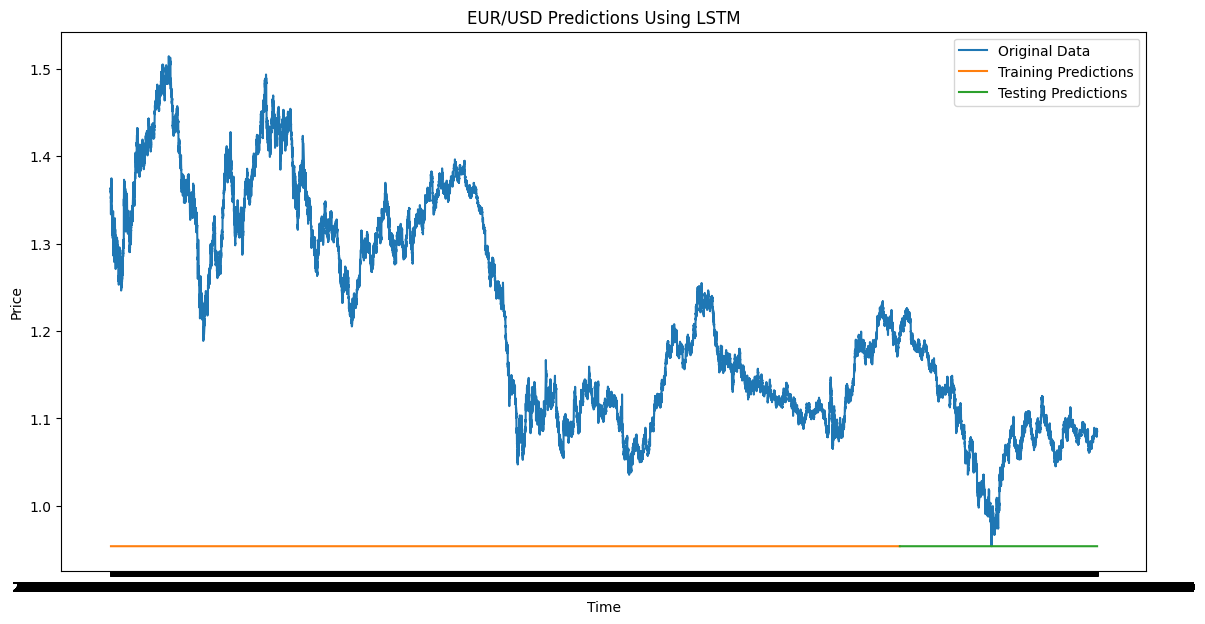

Original Data  Training Predictions  \
2009-01-05 14:00:00+00:00        1.36341                   NaN   
2009-01-05 15:00:00+00:00        1.36341                   NaN   
2009-01-05 16:00:00+00:00        1.35766                   NaN   
2009-01-05 17:00:00+00:00        1.35818                   NaN   
2009-01-05 18:00:00+00:00        1.36016                   NaN   
2009-01-05 19:00:00+00:00        1.36024                   NaN   
2009-01-05 20:00:00+00:00        1.35757                   NaN   
2009-01-05 21:00:00+00:00        1.36353                   NaN   
2009-01-05 22:00:00+00:00        1.36306                   NaN   
2009-01-05 23:00:00+00:00        1.36372                   NaN   
2009-01-06 00:00:00+00:00        1.35909                   NaN   
2009-01-06 01:00:00+00:00        1.35802                   NaN   
2009-01-06 02:00:00+00:00        1.35916                   NaN   
2009-01-06 03:00:00+00:00        1.36035                   NaN   
2009-01-06 04:00:00+00:00        1.35564                   NaN   
2009-01-06 05:00:00+00:00        1.35135                   NaN   
2009-01-06 06:00:00+00:00        1.35397                   NaN   
2009-01-06 07:00:00+00:00        1.34651                   NaN   
2009-01-06 08:00:00+00:00        1.34257                   NaN   
2009-01-06 09:00:00+00:00        1.34326                   NaN   
2009-01-06 10:00:00+00:00        1.33841                   NaN   
2009-01-06 11:00:00+00:00        1.33340                   NaN   
2009-01-06 12:00:00+00:00        1.33340                   NaN   
2009-01-06 13:00:00+00:00        1.33818                   NaN   
2009-01-06 14:00:00+00:00        1.34171               0.95394   
2009-01-06 15:00:00+00:00        1.33792               0.95394   
2009-01-06 16:00:00+00:00        1.34448               0.95394   
2009-01-06 17:00:00+00:00        1.34972               0.95394   
2009-01-06 18:00:00+00:00        1.34668               0.95394   
2009-01-06 19:00:00+00:00        1.35205               0.95394   

                           Testing Predictions  
2009-01-05 14:00:00+00:00                  NaN  
2009-01-05 15:00:00+00:00                  NaN  
2009-01-05 16:00:00+00:00                  NaN  
2009-01-05 17:00:00+00:00                  NaN  
2009-01-05 18:00:00+00:00                  NaN  
2009-01-05 19:00:00+00:00                  NaN  
2009-01-05 20:00:00+00:00                  NaN  
2009-01-05 21:00:00+00:00                  NaN  
2009-01-05 22:00:00+00:00                  NaN  
2009-01-05 23:00:00+00:00                  NaN  
2009-01-06 00:00:00+00:00                  NaN  
2009-01-06 01:00:00+00:00                  NaN  
2009-01-06 02:00:00+00:00                  NaN  
2009-01-06 03:00:00+00:00                  NaN  
2009-01-06 04:00:00+00:00                  NaN  
2009-01-06 05:00:00+00:00                  NaN  
2009-01-06 06:00:00+00:00                  NaN  
2009-01-06 07:00:00+00:00                  NaN  
2009-01-06 08:00:00+00:00                  NaN  
2009-01-06 09:00:00+00:00                  NaN  
2009-01-06 10:00:00+00:00                  NaN  
2009-01-06 11:00:00+00:00                  NaN  
2009-01-06 12:00:00+00:00                  NaN  
2009-01-06 13:00:00+00:00                  NaN  
2009-01-06 14:00:00+00:00                  NaN  
2009-01-06 15:00:00+00:00                  NaN  
2009-01-06 16:00:00+00:00                  NaN  
2009-01-06 17:00:00+00:00                  NaN  
2009-01-06 18:00:00+00:00                  NaN  
2009-01-06 19:00:00+00:00                  NaN

In [29]:

# Create a DataFrame with the results
results_df = pd.DataFrame(index=data.index)
results_df['Original Data'] = data['mid_c']
results_df.loc[train_index, 'Training Predictions'] = train_predict
results_df = results_df.reindex(results_df.index.union(test_index))
results_df.loc[test_index, 'Testing Predictions'] = test_predict

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(results_df['Original Data'], label='Original Data')
plt.plot(results_df['Training Predictions'], label='Training Predictions')
plt.plot(results_df['Testing Predictions'], label='Testing Predictions')
plt.title('EUR/USD Predictions Using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display the DataFrame
results_df.head(30)  # Displaying the first 30 rows for a quick check

# Discussion/Conclusion/Results
The results of the inital model gave prediction prices for the next 24 hour price points for the EUR_USD currency pair. However, in foresight I should have ran this on a day with tradeable data. Since I ran and trained the model over the weekend it prevented me from geting the actual price to compare performance. The intial model needs to be further developed because the Fiancial currency markets are much more volatile to be accurately predicted using price data alone. With the further development I plan to implement
- Sentiment Analyis
- Fine-Tuned Candlestick analysis and Price Action
- Risk Management Systems
- Extensive Backtesting Automations


In conclusion, the LSTM model could be a profitable algorithm to be used to predict the hourly closing prices of the EUR/USD currency pair and other Currency pair markets. It shows it's promises in this use case for me by demonstrating the model's capability to capture temporal dependencies in time series data. The addition of more advanced technical indicators will further enhanced the model's performance and layering in other models developed will attribute to higher accuracies in theory. While the results are promising, further improvements will be made by incorporating more features, fine-tuning hyperparameters, and exploring other deep learning architectures. 
